# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
# import os
# import time

# wait_to_make = "trained_list/deberta-base-trans.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    


In [2]:
EXP_NAME = "funnel-large-transformer"


In [3]:
# !nvidia-smi

In [4]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "funnel-transformer/large"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=8
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=4
    passfold = [0]
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig,AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.0
transformers.__version__: 4.16.2
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

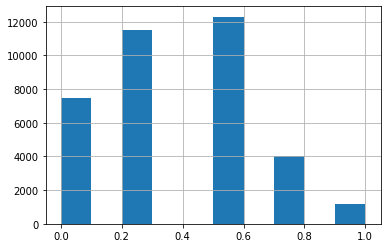

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# !pip install --no-cache-dir sentencepiece

In [20]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



# Dataset

In [21]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 125


In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [23]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [24]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output

In [25]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()

        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [26]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.feature_extractor = AutoModelForTokenClassification.from_pretrained("microsoft/deberta-v3-large")
#         self.feature_extractor.save_pretrained(OUTPUT_DIR+'extractor/')
#         # self.feature_extractor = AutoModelForTokenClassification.from_pretrained(OUTPUT_DIR+'extractor/')
#         in_features = self.feature_extractor.classifier.in_features
#         self.attention = TransformerHead(in_features=in_features, max_length=133, num_layers=1, nhead=8, num_targets=1)
                
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         weights = self.attention(weights)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output

In [27]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        # self.feature_extractor = AutoModelForTokenClassification.from_pretrained(OUTPUT_DIR+'extractor/')
        self.feature_extractor = AutoModelForTokenClassification.from_pretrained(CFG.model,)
        self.feature_extractor.save_pretrained(OUTPUT_DIR+'extractor/')
        in_features = self.feature_extractor.classifier.in_features
        self.attention = TransformerHead(in_features=in_features, max_length=cfg.max_len, num_layers=1, nhead=8, num_targets=1)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        feature = self.attention(last_hidden_states)
        
        return feature


    def forward(self, inputs):
        feature = self.feature(inputs)
        try:
            output = self.fc(self.fc_dropout(feature))
        except Exception as e:
            print(feature.shape)
            print(e)
            exit()
        return output

# Helpler functions

In [28]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [29]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            LOGGER.info(f"========== fold: {fold} training ==========")

            if fold in CFG.passfold:continue
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of FunnelForTokenClassification were not initialized from the model checkpoint at funnel-transformer/large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: [1][0/6838] Elapsed 0m 0s (remain 56m 40s) Loss: 0.7860(0.7860) Grad: inf  LR: 0.00002000  
Epoch: [1][100/6838] Elapsed 0m 31s (remain 34m 28s) Loss: 0.6806(0.7151) Grad: 42895.8945  LR: 0.00002000  
Epoch: [1][200/6838] Elapsed 1m 1s (remain 33m 55s) Loss: 0.6257(0.7043) Grad: 35680.6836  LR: 0.00002000  
Epoch: [1][300/6838] Elapsed 1m 32s (remain 33m 26s) Loss: 0.7043(0.6929) Grad: 22077.7969  LR: 0.00002000  
Epoch: [1][400/6838] Elapsed 2m 2s (remain 32m 54s) Loss: 0.7631(0.6858) Grad: 80467.4844  LR: 0.00002000  
Epoch: [1][500/6838] Elapsed 2m 33s (remain 32m 21s) Loss: 0.7119(0.6830) Grad: 97452.2266  LR: 0.00002000  
Epoch: [1][600/6838] Elapsed 3m 4s (remain 31m 50s) Loss: 0.6031(0.6771) Grad: 26574.7520  LR: 0.00001999  
Epoch: [1][700/6838] Elapsed 3m 34s (remain 31m 20s) Loss: 0.4465(0.6714) Grad: 49501.3594  LR: 0.00001999  
Epoch: [1][800/6838] Elapsed 4m 5s (remain 30m 50s) Loss: 0.6189(0.6635) Grad: 16596.3965  LR: 0.00001999  
Epoch: [1][900/6838] Elapsed 4m 3

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/2280] Elapsed 0m 0s (remain 7m 13s) Loss: 0.5954(0.5954) 
EVAL: [100/2280] Elapsed 0m 5s (remain 1m 58s) Loss: 0.6721(0.5341) 
EVAL: [200/2280] Elapsed 0m 10s (remain 1m 52s) Loss: 0.5062(0.5477) 
EVAL: [300/2280] Elapsed 0m 16s (remain 1m 46s) Loss: 0.6397(0.5503) 
EVAL: [400/2280] Elapsed 0m 21s (remain 1m 41s) Loss: 0.5535(0.5543) 
EVAL: [500/2280] Elapsed 0m 26s (remain 1m 35s) Loss: 0.4913(0.5592) 
EVAL: [600/2280] Elapsed 0m 32s (remain 1m 29s) Loss: 0.6204(0.5628) 
EVAL: [700/2280] Elapsed 0m 37s (remain 1m 25s) Loss: 0.5263(0.5674) 
EVAL: [800/2280] Elapsed 0m 43s (remain 1m 19s) Loss: 0.5063(0.5634) 
EVAL: [900/2280] Elapsed 0m 48s (remain 1m 14s) Loss: 0.5786(0.5631) 
EVAL: [1000/2280] Elapsed 0m 53s (remain 1m 8s) Loss: 1.2918(0.5663) 
EVAL: [1100/2280] Elapsed 0m 59s (remain 1m 3s) Loss: 0.8993(0.5661) 
EVAL: [1200/2280] Elapsed 1m 4s (remain 0m 57s) Loss: 0.5596(0.5675) 
EVAL: [1300/2280] Elapsed 1m 9s (remain 0m 52s) Loss: 0.6912(0.5679) 
EVAL: [1400/2280] Elapse

Epoch 1 - avg_train_loss: 0.5929  avg_val_loss: 0.5704  time: 2215s
Epoch 1 - Score: 0.7914
Epoch 1 - Save Best Score: 0.7914 Model


EVAL: [2279/2280] Elapsed 2m 1s (remain 0m 0s) Loss: 1.1847(0.5704) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/6838] Elapsed 0m 0s (remain 69m 58s) Loss: 0.1140(0.1140) Grad: nan  LR: 0.00001924  
Epoch: [2][100/6838] Elapsed 0m 31s (remain 34m 31s) Loss: 0.4889(0.5469) Grad: 574931.6875  LR: 0.00001922  
Epoch: [2][200/6838] Elapsed 1m 1s (remain 33m 53s) Loss: 0.4931(0.5374) Grad: 17327.0527  LR: 0.00001919  
Epoch: [2][300/6838] Elapsed 1m 32s (remain 33m 21s) Loss: 0.5713(0.5377) Grad: 102930.7344  LR: 0.00001917  
Epoch: [2][400/6838] Elapsed 2m 2s (remain 32m 51s) Loss: 0.3006(0.5335) Grad: 18847.0332  LR: 0.00001915  
Epoch: [2][500/6838] Elapsed 2m 33s (remain 32m 20s) Loss: 0.5043(0.5380) Grad: 27786.0547  LR: 0.00001913  
Epoch: [2][600/6838] Elapsed 3m 3s (remain 31m 48s) Loss: 0.6244(0.5375) Grad: 30103.0527  LR: 0.00001910  
Epoch: [2][700/6838] Elapsed 3m 35s (remain 31m 23s) Loss: 0.5089(0.5407) Grad: 33664.7852  LR: 0.00001908  
Epoch: [2][800/6838] Elapsed 4m 5s (remain 30m 51s) Loss: 0.5230(0.5425) Grad: 69530.5547  LR: 0.00001905  
Epoch: [2][900/6838] Elapsed 4m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/2280] Elapsed 0m 0s (remain 6m 53s) Loss: 0.5440(0.5440) 
EVAL: [100/2280] Elapsed 0m 5s (remain 1m 52s) Loss: 0.6409(0.5471) 
EVAL: [200/2280] Elapsed 0m 10s (remain 1m 46s) Loss: 0.8125(0.5508) 
EVAL: [300/2280] Elapsed 0m 15s (remain 1m 40s) Loss: 0.6322(0.5516) 
EVAL: [400/2280] Elapsed 0m 20s (remain 1m 35s) Loss: 0.5280(0.5594) 
EVAL: [500/2280] Elapsed 0m 25s (remain 1m 30s) Loss: 0.4882(0.5657) 
EVAL: [600/2280] Elapsed 0m 30s (remain 1m 24s) Loss: 0.6191(0.5702) 
EVAL: [700/2280] Elapsed 0m 35s (remain 1m 19s) Loss: 0.5360(0.5725) 
EVAL: [800/2280] Elapsed 0m 40s (remain 1m 14s) Loss: 0.5313(0.5698) 
EVAL: [900/2280] Elapsed 0m 45s (remain 1m 9s) Loss: 0.7446(0.5690) 
EVAL: [1000/2280] Elapsed 0m 50s (remain 1m 4s) Loss: 1.4842(0.5751) 
EVAL: [1100/2280] Elapsed 0m 55s (remain 0m 59s) Loss: 0.3875(0.5736) 
EVAL: [1200/2280] Elapsed 1m 0s (remain 0m 54s) Loss: 0.5640(0.5746) 
EVAL: [1300/2280] Elapsed 1m 5s (remain 0m 49s) Loss: 0.6777(0.5740) 
EVAL: [1400/2280] Elapse

Epoch 2 - avg_train_loss: 0.5520  avg_val_loss: 0.5749  time: 2208s
Epoch 2 - Score: 0.8081
Epoch 2 - Save Best Score: 0.8081 Model


EVAL: [2279/2280] Elapsed 1m 55s (remain 0m 0s) Loss: 0.7221(0.5749) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/6838] Elapsed 0m 0s (remain 71m 42s) Loss: 0.2956(0.2956) Grad: 85816.6484  LR: 0.00001707  
Epoch: [3][100/6838] Elapsed 0m 29s (remain 33m 13s) Loss: 0.6933(0.5057) Grad: 40573.9688  LR: 0.00001703  
Epoch: [3][200/6838] Elapsed 0m 59s (remain 32m 37s) Loss: 0.5412(0.5144) Grad: 360463.3125  LR: 0.00001699  
Epoch: [3][300/6838] Elapsed 1m 28s (remain 32m 2s) Loss: 0.3083(0.5235) Grad: 28566.7676  LR: 0.00001695  
Epoch: [3][400/6838] Elapsed 1m 57s (remain 31m 33s) Loss: 0.1432(0.5174) Grad: 6109.1924  LR: 0.00001691  
Epoch: [3][500/6838] Elapsed 2m 27s (remain 31m 4s) Loss: 0.7286(0.5244) Grad: 302450.5000  LR: 0.00001687  
Epoch: [3][600/6838] Elapsed 2m 56s (remain 30m 34s) Loss: 0.3748(0.5268) Grad: 73215.9219  LR: 0.00001682  
Epoch: [3][700/6838] Elapsed 3m 26s (remain 30m 5s) Loss: 0.5226(0.5272) Grad: 12025.1406  LR: 0.00001678  
Epoch: [3][800/6838] Elapsed 3m 55s (remain 29m 35s) Loss: 0.6016(0.5229) Grad: 10035.7842  LR: 0.00001674  
Epoch: [3][900/6838] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/2280] Elapsed 0m 5s (remain 194m 37s) Loss: 0.7208(0.7208) 
EVAL: [100/2280] Elapsed 0m 33s (remain 11m 52s) Loss: 0.6418(0.5477) 
EVAL: [200/2280] Elapsed 1m 1s (remain 10m 34s) Loss: 0.8780(0.5627) 
EVAL: [300/2280] Elapsed 1m 29s (remain 9m 45s) Loss: 0.6441(0.5697) 
EVAL: [400/2280] Elapsed 2m 25s (remain 11m 21s) Loss: 0.4946(0.5703) 
EVAL: [500/2280] Elapsed 2m 43s (remain 9m 41s) Loss: 0.4908(0.5656) 
EVAL: [600/2280] Elapsed 3m 4s (remain 8m 34s) Loss: 0.6119(0.5726) 
EVAL: [700/2280] Elapsed 3m 26s (remain 7m 44s) Loss: 0.5231(0.5812) 
EVAL: [800/2280] Elapsed 3m 47s (remain 7m 0s) Loss: 0.4892(0.5824) 
EVAL: [900/2280] Elapsed 4m 11s (remain 6m 24s) Loss: 0.7072(0.5821) 
EVAL: [1000/2280] Elapsed 4m 32s (remain 5m 47s) Loss: 0.6640(0.5850) 
EVAL: [1100/2280] Elapsed 4m 55s (remain 5m 16s) Loss: 0.3461(0.5840) 
EVAL: [1200/2280] Elapsed 5m 16s (remain 4m 44s) Loss: 0.5485(0.5852) 
EVAL: [1300/2280] Elapsed 5m 40s (remain 4m 16s) Loss: 0.6691(0.5835) 
EVAL: [1400/2280]

Epoch 3 - avg_train_loss: 0.5291  avg_val_loss: 0.5871  time: 3299s
Epoch 3 - Score: 0.7978
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/6838] Elapsed 0m 3s (remain 422m 6s) Loss: 0.4678(0.4678) Grad: 35084.9805  LR: 0.00001383  
Epoch: [4][100/6838] Elapsed 2m 20s (remain 156m 19s) Loss: 0.6390(0.5307) Grad: 308112.5312  LR: 0.00001377  
Epoch: [4][200/6838] Elapsed 4m 31s (remain 149m 20s) Loss: 0.3481(0.5330) Grad: 8275.0898  LR: 0.00001372  
Epoch: [4][300/6838] Elapsed 6m 33s (remain 142m 17s) Loss: 0.4981(0.5280) Grad: 14457.4717  LR: 0.00001367  
Epoch: [4][400/6838] Elapsed 8m 17s (remain 133m 1s) Loss: 0.4934(0.5223) Grad: 10138.7988  LR: 0.00001361  
Epoch: [4][500/6838] Elapsed 10m 1s (remain 126m 52s) Loss: 0.1406(0.5172) Grad: 1455.7040  LR: 0.00001356  
Epoch: [4][600/6838] Elapsed 11m 51s (remain 123m 6s) Loss: 0.4246(0.5187) Grad: 6620.7915  LR: 0.00001351  
Epoch: [4][700/6838] Elapsed 13m 43s (remain 120m 8s) Loss: 0.3431(0.5165) Grad: 30177.3496  LR: 0.00001345  
Epoch: [4][800/6838] Elapsed 15m 25s (remain 116m 12s) Loss: 0.6678(0.5138) Grad: 8301.1904  LR: 0.00001340  
Epoch: [4][900/68

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/2280] Elapsed 0m 1s (remain 75m 3s) Loss: 0.8580(0.8580) 
EVAL: [100/2280] Elapsed 0m 18s (remain 6m 29s) Loss: 0.6512(0.5447) 
EVAL: [200/2280] Elapsed 0m 33s (remain 5m 51s) Loss: 0.6569(0.5628) 
EVAL: [300/2280] Elapsed 0m 51s (remain 5m 37s) Loss: 0.6329(0.5619) 
EVAL: [400/2280] Elapsed 1m 6s (remain 5m 11s) Loss: 0.5878(0.5663) 
EVAL: [500/2280] Elapsed 1m 24s (remain 4m 58s) Loss: 0.4878(0.5671) 
EVAL: [600/2280] Elapsed 1m 40s (remain 4m 39s) Loss: 0.6384(0.5723) 
EVAL: [700/2280] Elapsed 1m 58s (remain 4m 25s) Loss: 0.5229(0.5748) 
EVAL: [800/2280] Elapsed 2m 13s (remain 4m 7s) Loss: 0.5423(0.5715) 
EVAL: [900/2280] Elapsed 2m 29s (remain 3m 48s) Loss: 0.5635(0.5689) 
EVAL: [1000/2280] Elapsed 2m 48s (remain 3m 34s) Loss: 0.9328(0.5706) 
EVAL: [1100/2280] Elapsed 3m 4s (remain 3m 17s) Loss: 0.4033(0.5709) 
EVAL: [1200/2280] Elapsed 3m 22s (remain 3m 1s) Loss: 0.5674(0.5720) 
EVAL: [1300/2280] Elapsed 3m 39s (remain 2m 44s) Loss: 0.6860(0.5717) 
EVAL: [1400/2280] Elaps

Epoch 4 - avg_train_loss: 0.5155  avg_val_loss: 0.5755  time: 7211s
Epoch 4 - Score: 0.8302
Epoch 4 - Save Best Score: 0.8302 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/6838] Elapsed 0m 2s (remain 310m 30s) Loss: 0.1481(0.1481) Grad: 90526.0391  LR: 0.00001000  
Epoch: [5][100/6838] Elapsed 1m 38s (remain 109m 34s) Loss: 0.4922(0.5018) Grad: 84908.1250  LR: 0.00000994  
Epoch: [5][200/6838] Elapsed 3m 12s (remain 105m 53s) Loss: 0.5041(0.5045) Grad: 29308.5137  LR: 0.00000989  
Epoch: [5][300/6838] Elapsed 4m 18s (remain 93m 39s) Loss: 0.4607(0.5006) Grad: 13817.6572  LR: 0.00000983  
Epoch: [5][400/6838] Elapsed 5m 45s (remain 92m 33s) Loss: 0.4365(0.4983) Grad: 36553.9922  LR: 0.00000977  
Epoch: [5][500/6838] Elapsed 7m 16s (remain 92m 2s) Loss: 0.5968(0.5035) Grad: 15286.1787  LR: 0.00000971  
Epoch: [5][600/6838] Elapsed 8m 47s (remain 91m 10s) Loss: 0.4546(0.5059) Grad: 51248.6016  LR: 0.00000966  
Epoch: [5][700/6838] Elapsed 10m 16s (remain 89m 54s) Loss: 0.4375(0.5061) Grad: 46774.2969  LR: 0.00000960  
Epoch: [5][800/6838] Elapsed 11m 46s (remain 88m 44s) Loss: 0.3512(0.5073) Grad: 15651.0752  LR: 0.00000954  
Epoch: [5][900/683

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/2280] Elapsed 0m 1s (remain 74m 41s) Loss: 1.1999(1.1999) 
EVAL: [100/2280] Elapsed 0m 16s (remain 5m 57s) Loss: 0.6370(0.5592) 
EVAL: [200/2280] Elapsed 0m 31s (remain 5m 25s) Loss: 0.9980(0.5947) 
EVAL: [300/2280] Elapsed 0m 47s (remain 5m 13s) Loss: 0.6316(0.5898) 
EVAL: [400/2280] Elapsed 1m 2s (remain 4m 50s) Loss: 0.5180(0.5975) 
EVAL: [500/2280] Elapsed 1m 16s (remain 4m 31s) Loss: 0.4872(0.6029) 
EVAL: [600/2280] Elapsed 1m 33s (remain 4m 19s) Loss: 0.6291(0.6031) 
EVAL: [700/2280] Elapsed 1m 47s (remain 4m 3s) Loss: 0.5211(0.6046) 
EVAL: [800/2280] Elapsed 2m 5s (remain 3m 52s) Loss: 0.4985(0.6014) 
EVAL: [900/2280] Elapsed 2m 21s (remain 3m 36s) Loss: 0.5624(0.5984) 
EVAL: [1000/2280] Elapsed 2m 36s (remain 3m 20s) Loss: 0.6565(0.6002) 
EVAL: [1100/2280] Elapsed 2m 54s (remain 3m 7s) Loss: 0.3722(0.6005) 
EVAL: [1200/2280] Elapsed 3m 8s (remain 2m 49s) Loss: 0.5578(0.6027) 
EVAL: [1300/2280] Elapsed 3m 22s (remain 2m 32s) Loss: 0.6605(0.6035) 
EVAL: [1400/2280] Elaps

Epoch 5 - avg_train_loss: 0.5033  avg_val_loss: 0.6060  time: 6464s
Epoch 5 - Score: 0.8393
Epoch 5 - Save Best Score: 0.8393 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/6838] Elapsed 0m 0s (remain 43m 38s) Loss: 0.1737(0.1737) Grad: 9932.6064  LR: 0.00000617  
Epoch: [6][100/6838] Elapsed 1m 32s (remain 102m 42s) Loss: 0.7863(0.5056) Grad: nan  LR: 0.00000612  
Epoch: [6][200/6838] Elapsed 3m 2s (remain 100m 27s) Loss: 0.6324(0.5089) Grad: 13595.2061  LR: 0.00000607  
Epoch: [6][300/6838] Elapsed 4m 35s (remain 99m 48s) Loss: 0.5234(0.5081) Grad: 14946.4541  LR: 0.00000602  
Epoch: [6][400/6838] Elapsed 6m 3s (remain 97m 9s) Loss: 0.5194(0.4997) Grad: 56116.8047  LR: 0.00000596  
Epoch: [6][500/6838] Elapsed 7m 33s (remain 95m 32s) Loss: 0.2817(0.5044) Grad: 2546.8423  LR: 0.00000591  
Epoch: [6][600/6838] Elapsed 9m 3s (remain 93m 57s) Loss: 0.6290(0.5045) Grad: 4355.8823  LR: 0.00000586  
Epoch: [6][700/6838] Elapsed 10m 33s (remain 92m 21s) Loss: 0.6370(0.5032) Grad: 5093.8828  LR: 0.00000581  
Epoch: [6][800/6838] Elapsed 12m 2s (remain 90m 45s) Loss: 0.6616(0.5012) Grad: 5131.1670  LR: 0.00000575  
Epoch: [6][900/6838] Elapsed 13m 32

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/2280] Elapsed 0m 0s (remain 7m 38s) Loss: 1.0265(1.0265) 
EVAL: [100/2280] Elapsed 0m 16s (remain 5m 53s) Loss: 0.6583(0.5573) 
EVAL: [200/2280] Elapsed 0m 31s (remain 5m 21s) Loss: 0.4932(0.5744) 
EVAL: [300/2280] Elapsed 0m 45s (remain 5m 0s) Loss: 0.6287(0.5648) 
EVAL: [400/2280] Elapsed 1m 1s (remain 4m 49s) Loss: 0.5842(0.5746) 
EVAL: [500/2280] Elapsed 1m 18s (remain 4m 37s) Loss: 0.4875(0.5805) 
EVAL: [600/2280] Elapsed 1m 32s (remain 4m 18s) Loss: 0.6320(0.5830) 
EVAL: [700/2280] Elapsed 1m 48s (remain 4m 5s) Loss: 0.5200(0.5830) 
EVAL: [800/2280] Elapsed 2m 3s (remain 3m 48s) Loss: 0.5389(0.5815) 
EVAL: [900/2280] Elapsed 2m 18s (remain 3m 32s) Loss: 0.5654(0.5799) 
EVAL: [1000/2280] Elapsed 2m 35s (remain 3m 18s) Loss: 0.6262(0.5816) 
EVAL: [1100/2280] Elapsed 2m 51s (remain 3m 3s) Loss: 0.3590(0.5809) 
EVAL: [1200/2280] Elapsed 3m 6s (remain 2m 47s) Loss: 0.5485(0.5827) 
EVAL: [1300/2280] Elapsed 3m 23s (remain 2m 32s) Loss: 0.6611(0.5819) 
EVAL: [1400/2280] Elapsed

Epoch 6 - avg_train_loss: 0.4963  avg_val_loss: 0.5830  time: 6442s
Epoch 6 - Score: 0.8379
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/6838] Elapsed 0m 0s (remain 45m 39s) Loss: 0.5637(0.5637) Grad: 15531.4736  LR: 0.00000293  
Epoch: [7][100/6838] Elapsed 1m 34s (remain 104m 39s) Loss: 0.4891(0.4860) Grad: 12054.4795  LR: 0.00000289  
Epoch: [7][200/6838] Elapsed 3m 3s (remain 100m 57s) Loss: 0.4873(0.4871) Grad: 3265.2603  LR: 0.00000285  
Epoch: [7][300/6838] Elapsed 4m 30s (remain 98m 1s) Loss: 0.6932(0.4984) Grad: 1387.0486  LR: 0.00000281  
Epoch: [7][400/6838] Elapsed 5m 56s (remain 95m 23s) Loss: 0.5956(0.4964) Grad: 4442.6479  LR: 0.00000277  
Epoch: [7][500/6838] Elapsed 7m 25s (remain 93m 48s) Loss: 0.3049(0.4933) Grad: 25932.8906  LR: 0.00000273  
Epoch: [7][600/6838] Elapsed 8m 54s (remain 92m 26s) Loss: 0.5202(0.4908) Grad: 3495.5737  LR: 0.00000269  
Epoch: [7][700/6838] Elapsed 10m 22s (remain 90m 52s) Loss: 0.6301(0.4887) Grad: 7667.1865  LR: 0.00000265  
Epoch: [7][800/6838] Elapsed 11m 51s (remain 89m 21s) Loss: 0.4549(0.4897) Grad: 4763.9517  LR: 0.00000261  
Epoch: [7][900/6838] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][6837/6838] Elapsed 99m 52s (remain 0m 0s) Loss: 0.1412(0.4904) Grad: 1777.7988  LR: 0.00000076  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/2280] Elapsed 0m 1s (remain 74m 9s) Loss: 1.2070(1.2070) 
EVAL: [100/2280] Elapsed 0m 16s (remain 5m 54s) Loss: 0.6581(0.5740) 
EVAL: [200/2280] Elapsed 0m 30s (remain 5m 18s) Loss: 0.5193(0.6026) 
EVAL: [300/2280] Elapsed 0m 46s (remain 5m 4s) Loss: 0.6282(0.5930) 
EVAL: [400/2280] Elapsed 1m 0s (remain 4m 42s) Loss: 0.5808(0.6018) 
EVAL: [500/2280] Elapsed 1m 15s (remain 4m 28s) Loss: 0.4876(0.6070) 
EVAL: [600/2280] Elapsed 1m 29s (remain 4m 11s) Loss: 0.6180(0.6064) 
EVAL: [700/2280] Elapsed 1m 44s (remain 3m 55s) Loss: 0.5199(0.6042) 
EVAL: [800/2280] Elapsed 1m 58s (remain 3m 39s) Loss: 0.4912(0.6013) 
EVAL: [900/2280] Elapsed 2m 13s (remain 3m 24s) Loss: 0.5677(0.5994) 
EVAL: [1000/2280] Elapsed 2m 27s (remain 3m 8s) Loss: 0.6328(0.6014) 
EVAL: [1100/2280] Elapsed 2m 41s (remain 2m 53s) Loss: 0.3567(0.6009) 
EVAL: [1200/2280] Elapsed 2m 56s (remain 2m 38s) Loss: 0.5517(0.6045) 
EVAL: [1300/2280] Elapsed 3m 10s (remain 2m 23s) Loss: 0.6605(0.6041) 
EVAL: [1400/2280] Elap

Epoch 7 - avg_train_loss: 0.4904  avg_val_loss: 0.6051  time: 6320s
Epoch 7 - Score: 0.8377
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/6838] Elapsed 0m 0s (remain 41m 22s) Loss: 0.2812(0.2812) Grad: 10049.2031  LR: 0.00000076  
Epoch: [8][100/6838] Elapsed 1m 21s (remain 91m 8s) Loss: 0.4550(0.4824) Grad: 1505.5465  LR: 0.00000074  
Epoch: [8][200/6838] Elapsed 2m 41s (remain 88m 49s) Loss: 0.4872(0.4887) Grad: 2176.2776  LR: 0.00000072  
Epoch: [8][300/6838] Elapsed 4m 6s (remain 89m 10s) Loss: 0.4895(0.4785) Grad: 29085.8379  LR: 0.00000070  
Epoch: [8][400/6838] Elapsed 5m 34s (remain 89m 26s) Loss: 0.4554(0.4790) Grad: 16119.1006  LR: 0.00000068  
Epoch: [8][500/6838] Elapsed 7m 1s (remain 88m 55s) Loss: 0.4939(0.4820) Grad: 30417.3906  LR: 0.00000066  
Epoch: [8][600/6838] Elapsed 8m 30s (remain 88m 16s) Loss: 0.4545(0.4839) Grad: 767.0538  LR: 0.00000064  
Epoch: [8][700/6838] Elapsed 9m 59s (remain 87m 28s) Loss: 0.5954(0.4867) Grad: 2136.8411  LR: 0.00000062  
Epoch: [8][800/6838] Elapsed 11m 29s (remain 86m 37s) Loss: 0.4949(0.4854) Grad: 48970.5625  LR: 0.00000060  
Epoch: [8][900/6838] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/2280] Elapsed 0m 0s (remain 7m 47s) Loss: 1.2516(1.2516) 
EVAL: [100/2280] Elapsed 0m 5s (remain 1m 59s) Loss: 0.6581(0.5783) 
EVAL: [200/2280] Elapsed 0m 10s (remain 1m 52s) Loss: 0.5326(0.6082) 
EVAL: [300/2280] Elapsed 0m 16s (remain 1m 46s) Loss: 0.6281(0.5994) 
EVAL: [400/2280] Elapsed 0m 21s (remain 1m 41s) Loss: 0.5731(0.6086) 
EVAL: [500/2280] Elapsed 0m 27s (remain 1m 36s) Loss: 0.4874(0.6146) 
EVAL: [600/2280] Elapsed 0m 32s (remain 1m 30s) Loss: 0.6094(0.6139) 
EVAL: [700/2280] Elapsed 0m 37s (remain 1m 25s) Loss: 0.5199(0.6109) 
EVAL: [800/2280] Elapsed 0m 43s (remain 1m 19s) Loss: 0.4905(0.6076) 
EVAL: [900/2280] Elapsed 0m 48s (remain 1m 14s) Loss: 0.5748(0.6055) 
EVAL: [1000/2280] Elapsed 0m 54s (remain 1m 9s) Loss: 0.6321(0.6075) 
EVAL: [1100/2280] Elapsed 0m 59s (remain 1m 3s) Loss: 0.3534(0.6071) 
EVAL: [1200/2280] Elapsed 1m 4s (remain 0m 58s) Loss: 0.5528(0.6110) 
EVAL: [1300/2280] Elapsed 1m 10s (remain 0m 52s) Loss: 0.6605(0.6107) 
EVAL: [1400/2280] Elaps

Epoch 8 - avg_train_loss: 0.4878  avg_val_loss: 0.6125  time: 4112s
Epoch 8 - Score: 0.8378
========== fold: 1 result ==========
Score: 0.8393
========== fold: 2 training ==========


========== fold: 2 training ==========


In [ ]:
print(f'{time.time()-start} hour')

In [ ]:
!touch trained_list/funnnel_trans.txt